In [1]:
import torch
from torch import nn
from torch.nn import functional as F

torch.manual_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Data

In [2]:
class RandomSequenceDataset(torch.utils.data.Dataset):

    def __init__(self, data, context_size, length):
        self.data = data
        self.context_size = context_size
        self.length = length  # сколько примеров хотим на эпоху

    
    def __len__(self):
        return self.length

    
    def __getitem__(self, idx):
        # просто игнорируем idx и семплируем случайно
        i = torch.randint(0, len(self.data) - self.context_size - 1, (1,)).item()
        x = self.data[i : i+self.context_size]
        y = self.data[i+1 : i+1+self.context_size]
        
        return x, y

In [3]:
with open("./data/tinyshakespeare.txt", "r", encoding="utf-8") as f:
    text = f.read()

text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [4]:
alphabet = sorted(list(set(text)))

vocab_size = len(alphabet)

ch2i = {ch: i for i, ch in enumerate(alphabet)}
i2ch = {i: ch for i, ch in enumerate(alphabet)}

encode = lambda s: [ch2i[ch] for ch in s]
decode = lambda l: "".join([i2ch[i] for i in l])

data = torch.tensor(encode(text))
n = int(0.9 * len(data))

# Attention Idea

In [ ]:
b, t, c = 4, 8, 2
x = torch.randn(b, t, c)
x.shape

In [ ]:
# Нужно связать токен с предыдущими, но не с последующими
# К примеру, усреднение вектора текущего токена с предыдущими 
# (теряется информация о расположении токенов, неэффективное представление)

# Неэффективный последовательно выполняющийся вариант 
xbow = torch.zeros((b, t, c))
for i_b in range(b):
    for i_t in range(t):
        xprev = x[i_b, :i_t+1]
        xbow[i_b, i_t] = torch.mean(xprev, 0)

# Распараллеленный вариант с матричным умножением 
wei = torch.tril(torch.ones(t, t))  # треугольная матрица
wei /= wei.sum(1, keepdim=True)  # при t = 2: [[1, 0], [0.5, 0.5]]
xbow2 = wei @ x  # (t, t) @ (b, t, c) --broadcast--> (b, t, t) @ (b, t, c) -> (b, t, c)
print(torch.allclose(xbow, xbow2))

# С использованием Soft-Max
tril = torch.tril(torch.ones(t, t))
wei = torch.zeros((t, t))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=1)
xbow3 = wei @ x
print(torch.allclose(xbow, xbow3))

True
True


# Transformer Components  (Attention is all you need - 2017)

In [5]:
class SelfAttentionHead(nn.Module):

    def __init__(self, head_size, emb_dim, context_size, dropout=0.2):
        super().__init__()
        self.queries = nn.Linear(emb_dim, head_size, bias=False)
        self.keys = nn.Linear(emb_dim, head_size, bias=False)
        self.values = nn.Linear(emb_dim, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)  # Dropout: a simple way to prevent nn from overfitting (2014)

        self.register_buffer("tril", torch.tril(torch.ones(context_size, context_size)))

    
    def forward(self, idx):
        b, t, c = idx.shape
        
        wei = self.keys(idx) @ self.queries(idx).transpose(-2, -1) * c ** (-0.5)
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float("-inf"))  # Диагональ применяется для блока декодера, 
                                                                      # в энкодер блоках допускается взаимосвязь между предыдущими и последующими токенами
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        return wei @ self.values(idx)
    

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size, emb_dim, context_size, dropout=0.2):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(head_size, emb_dim, context_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, num_heads * head_size)
        self.dropout = nn.Dropout(dropout)

    
    def forward(self, idx):
        out = torch.cat([h(idx) for h in self.heads], dim=-1)
        out = self.proj(out)  # Линейное преобразование
        
        return self.dropout(out)
    

class FeedForward(nn.Module):

    def __init__(self, emb_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.ReLU(),
            nn.Linear(4 * emb_dim, emb_dim),  # Линейное преобразование
            nn.Dropout(dropout),
        )

    
    def forward(self, idx):
        return self.net(idx)


class TrfBlock(nn.Module):
    
    def __init__(self, emb_dim, num_heads, context_size, dropout=0.2):
        super().__init__()
        self.sa_heads = MultiHeadAttention(
            num_heads=num_heads, 
            emb_dim=emb_dim,
            head_size=emb_dim // num_heads, 
            context_size=context_size,
            dropout=dropout,
        )
        self.ffwd_net = FeedForward(emb_dim, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(emb_dim)  # Layer Normalization (2016)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
    
    
    def forward(self, idx):
        x = idx + self.sa_heads(self.layer_norm1(idx))  # Deep Residual Learning for Image Recognition (2015)
        x = x + self.ffwd_net(self.layer_norm2(x))
        return x

# Model

In [6]:
class DecoderOnlyModel(nn.Module):
    
    def __init__(self, vocab_size, context_size, emb_dim, n_blocks, dropout=0.2):
        super().__init__()

        self.token_emb_table = nn.Embedding(vocab_size, emb_dim)
        self.positional_emb_table = nn.Embedding(context_size, emb_dim)
        self.blocks = nn.Sequential(*[
            TrfBlock(
                emb_dim=emb_dim, 
                num_heads=4, 
                context_size=context_size,
                dropout=dropout,
            ) for _ in range(n_blocks)
        ])
        self.layer_norm = nn.LayerNorm(emb_dim)
        self.classifier = nn.Linear(emb_dim, vocab_size)
            
    
    def forward(self, idx, targets=None):
        b, t = idx.shape

        tok_embs = self.token_emb_table(idx)  # batch_size x context_size x emb_dim
        pos_embs = self.positional_emb_table(torch.arange(t, device=idx.device))  # context_size x emb_dim
        x = tok_embs + pos_embs
        x = self.blocks(x)
        x = self.layer_norm(x)
        logits = self.classifier(x)  # (batch_size, context_size, emb_dim) @ (emb_dim, vocab_size) -> (batch_size, context_size, vocab_size)
        
        loss = None
        if targets is not None:
            batch_size, n_tensors, emb_dim = logits.shape
            logits = logits.view(batch_size * n_tensors, emb_dim)
            targets = targets.view(batch_size * n_tensors)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    

    def generate(self, idx, max_new_tokens, context_size):
        with torch.no_grad():
            for _ in range(max_new_tokens):
                idx_cond = idx[:, -context_size:]
                logits, _ = self(idx_cond)
                logits = logits[:, -1, :]  # Биграммная модель предсказывает, основываясь на последнем токене (-1)
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)  # Предсказание следующего токена
                idx = torch.cat((idx, idx_next), dim=1)
            
            return idx

# Train

In [7]:
context_size = 32  # what is the maximum context length for predictions?
batch_size = 256 # how many independent sequences will we process in parallel?
emb_dim = 32
n_blocks = 4
dropout = 0.1


model = DecoderOnlyModel(
    vocab_size=vocab_size,
    context_size=context_size,
    emb_dim=emb_dim,
    n_blocks=n_blocks,
    dropout=dropout,
).to(device)

print(sum(p.numel() for p in model.parameters()), "parameters")

train_dataset = RandomSequenceDataset(data[:n], context_size=context_size, length=n)
val_dataset = RandomSequenceDataset(data[n:], context_size=context_size, length=len(data)-n)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,          # используем 4 CPU-процесса для генерации данных
    pin_memory=True         # ускоренная передача на GPU
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=0,          # используем 4 CPU-процесса для генерации данных
    pin_memory=True         # ускоренная передача на GPU
)

55745 parameters


In [ ]:
from tqdm import tqdm 


epoches = 100

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

train_lossi = []
for epoch in range(epoches):
    print(f"{epoch=}")

    lossi = []
    model.train()
    for x, y in tqdm(train_dataloader):

        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        lossi.append(loss.item())

    print("mean_train_loss:", sum(lossi) / len(lossi))
    train_lossi.extend(lossi)

    lossi = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_dataloader):

            x, y = x.to(device), y.to(device)
            logits, loss = model(idx=x, targets=y)

            lossi.append(loss.item())
    
    print("mean_val_loss:", sum(lossi) / len(lossi))

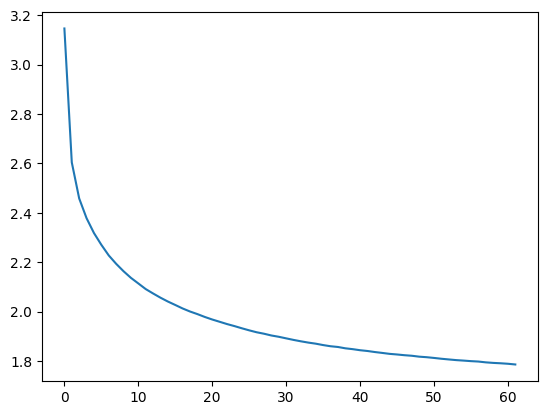

In [16]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(train_lossi[:62000]).view(-1, 1000).mean(1))

In [10]:
print(
    decode(
        model.generate(
            idx=torch.zeros((1, 1), dtype=torch.long, device=device), 
            max_new_tokens=1000, 
            context_size=context_size,
        )[0].tolist()
    )
)


Windoon Lord whe'd ecave and leave.

RADY LOVERS:
Cowambead,
apout,
But musie
The daznot, son is therefechy a plechars,-Is wount her jemesw mut not suppettier:
He go ast I nleast my orns!

Sich, Frong hold's which the doud lovet,
For long on Sheect.

ANTING VI:
And houbt his bothery peady
Metayen take Pearicty 'Tance?  would man wouseds it, do do him sire,
Will the to thee sis, let the augh that am the very mirggtients.

MERA:
And have me and I not Was Rind the pred.

ENRY ARICANT:
Prinst if mering lipter no his mutter of is worter's fnot!
AnTwant the landy as own, let
To have seek of yoursh tore be there lead old liegue.
Plut pown: Marct-love to faise,
There the canstle, got, not, you set time sead pervalliated
Tone secout heself.
Kor In hurmake of your acurstings at she't.
Riciatness' dided the to deart anod, cher cland pecerful buthild this my
To than
your wixth that or bear
they be all on toiled had enremary:
For that strum. She:
Oe, my prisous him
Off this, Lady bud faughtser? wh